In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
data = pd.read_csv("C:/Users/msteinme/Documents/CFUrea.csv")
df = data[['Date','CF','Urea']]
print(df.tail())
#1/5/1996-5/27/2016

from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
date = df['Date']
df.dtypes

          Date     CF  Urea
563  5/27/2016  27.70   189
564   6/3/2016  28.61   180
565  6/10/2016  29.23   182
566  6/17/2016  28.35   185
567  6/24/2016  25.26   182


Date    datetime64[ns]
CF             float64
Urea             int64
dtype: object

In [4]:
df.index = df['Date'].values
df = df.drop(['Date'],axis=1)
df.head(2)

,CF,Urea
2005-08-12,3.586,255
2005-08-19,3.320,255


In [13]:
df.corr() #no correlation with no lead or lag

,CF,Urea
CF,1.000000,0.262376
Urea,0.262376,1.000000


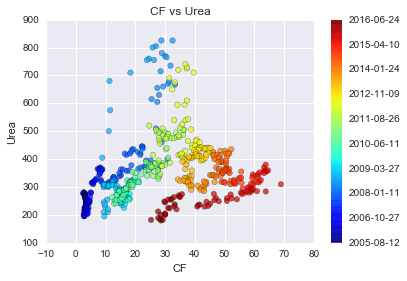

In [5]:
# Plot data and use colormap to indicate the date each point corresponds to
X = df[['CF']]
Y = df[['Urea']]
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(X))
sc = plt.scatter(X, Y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in X[::len(X)//9].index])
plt.title('CF vs Urea')
plt.xlabel('CF')
plt.ylabel('Urea')
#looking at this maybe try looking at just 2015 since every couple of years the slope tends to change

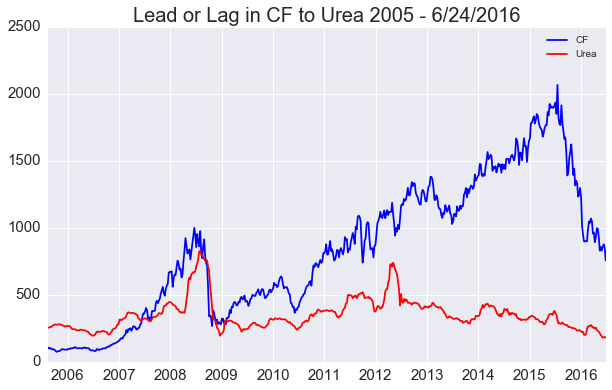

In [12]:
#trend, just modify to look at the different variables and scaling
y1 = (df['CF'])*30
y2 = (df['Urea'])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(y1,'b')
ax.plot(y2,'r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title('Lead or Lag in CF to Urea 2005 - 6/24/2016', size=(20))
ax.tick_params(axis='x',which='major',labelsize=15)
ax.tick_params(axis='y',which='major',labelsize=15)
plt.show()

In [14]:
import statsmodels.api as sm
tsa = sm.tsa

X = df[['CF']]
Y = df[['Urea']]
X= sm.add_constant(X)
est= sm.OLS(Y,X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Urea   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     41.84
Date:                Fri, 24 Jun 2016   Prob (F-statistic):           2.14e-10
Time:                        11:16:09   Log-Likelihood:                -3491.2
No. Observations:                 568   AIC:                             6986.
Df Residuals:                     566   BIC:                             6995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        303.0718      9.103     33.295      0.000       285.192   320.951
CF             1.8048      0.279      6.469      0.000         1.257     2.353
==============================================================================
Omnibus:                      211.755   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              676.136
Skew:                           1.795   Prob(JB):                    1.51e-147
Kurtosis:                       6.961   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
acf, Q, pvalue = tsa.acf(est.resid, nlags=4, qstat=True,unbiased=True)
print(tsa.pacf(est.resid, nlags=4))
print(acf)
print(Q)
print(pvalue)

[ 1.          0.98669864 -0.32110269 -0.25090023 -0.12609115]
[ 1.          0.98669864  0.96508881  0.93524423  0.89915363]
[  555.91602127  1088.68793183  1589.90380833  2054.00415723]
[  6.50170867e-123   3.93024249e-237   0.00000000e+000   0.00000000e+000]


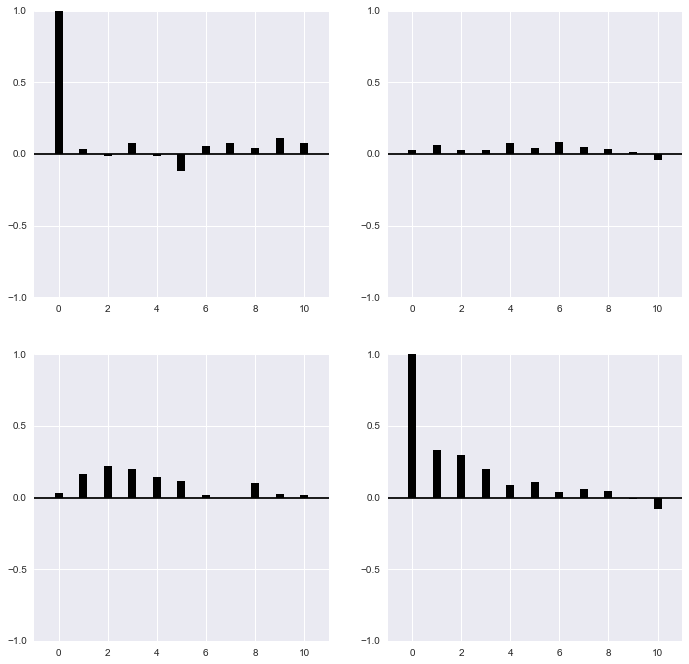

In [17]:
# fit the model with two lags of the log differentiated data, VAR sample autocorrelation
data = np.diff(np.log(df), axis=0)
model = tsa.VAR(data)
res = model.fit(2)
res.plot_sample_acorr() #cf-cf, then top right cf-urea

In [25]:
#lag order selection
model.select_order(100)#had at 15 but then changed to 100 due to the fact that around 100 graph below showed better corr
#only thing that changed was aic went from 12->31 (worse correlation)
#so looks like lag of 12 most common in choice, since weekly it would be 12 weeks, 
#can't just look at this though, other choice is 2 weeks

                  VAR Order Selection                  
             aic          bic          fpe         hqic
-------------------------------------------------------
0         -11.57       -11.56    9.411e-06       -11.57
1         -11.70       -11.65    8.305e-06       -11.68
2         -11.77      -11.68*    7.730e-06      -11.74*
3         -11.78       -11.66    7.628e-06       -11.73
4         -11.78       -11.62    7.660e-06       -11.72
5         -11.79       -11.60    7.545e-06       -11.72
6         -11.78       -11.55    7.622e-06       -11.69
7         -11.77       -11.50    7.724e-06       -11.67
8         -11.77       -11.47    7.733e-06       -11.65
9         -11.76       -11.43    7.782e-06       -11.63
10        -11.77       -11.40    7.750e-06       -11.62
11        -11.77       -11.36    7.755e-06       -11.61
12        -11.80       -11.36   7.513e-06*       -11.62
13        -11.79       -11.31    7.567e-06       -11.60
14        -11.78       -11.27    7.658e-06      

{'aic': 31, 'bic': 2, 'fpe': 12, 'hqic': 2}

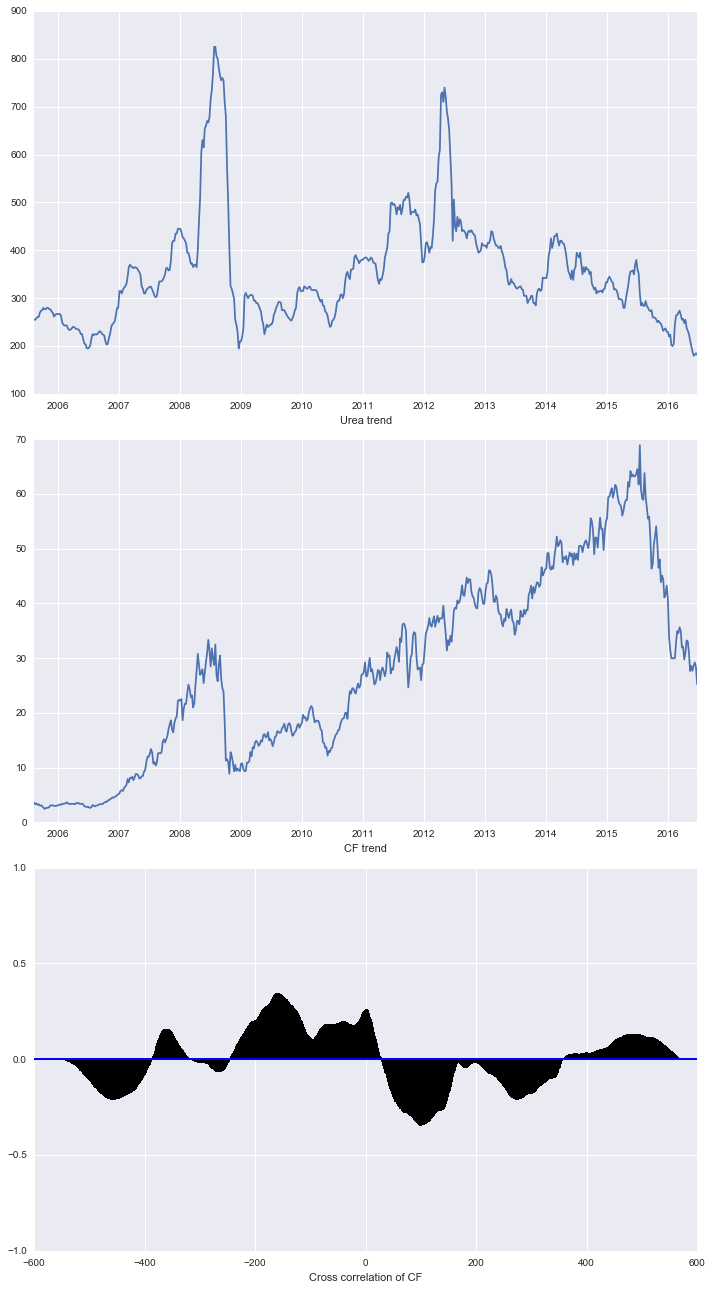

In [19]:
#CF vs Urea comparison
import matplotlib.pyplot as plt
import numpy as np

#use for first two subplots
cf1 = df[['CF']]
urea1 = df[['Urea']]

#need in this format for bottom subplot
cf = np.array(cf1)
urea = np.array(urea1)
cf = np.ravel(cf) #said array was too deep before I did the ravel
urea = np.ravel(urea)

total = sum(urea)
av = total / len(urea)
z = [i - av for i in urea]

# Now let's generate random data for the same period
assert len(urea) == len(cf)

total1 = sum(cf)
av1 = total1 / len(cf)
z1 = [i - av1 for i in cf]

fig = plt.figure(figsize=(10,18))
    
# Search trend 
ax1 = fig.add_subplot(311)
ax1.plot(urea1)
ax1.set_xlabel('Urea trend')

# PCS: "search trend"
ax2 = fig.add_subplot(312)
ax2.plot(cf1)
ax2.set_xlabel('CF trend')

# Is there a pattern in search trend for this keyword?
ax3 = fig.add_subplot(313)
ax3.set_xlabel('Cross correlation of CF')
ax3.xcorr(z,z1,usevlines=True, maxlags=None, normed=True, lw=2)
ax3.grid(True)
plt.ylim(-1, 1)

plt.tight_layout()

plt.show()
#no apparent correlations at any lead or lag, nothing below -0.5 and nothing greater than 0.5

In [20]:
np.correlate(cf,urea,mode='full')

array([   652.652,   1267.65 ,   1902.76 , ...,  21199.98 ,  13670.55 ,
         6441.3  ])

In [21]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print ('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [30]:
#0.262 corr to start at 0 lead
x = cf
y = urea
# this has cf starting at 0 and then it goes up to lead urea to 50
lagcorr(x,y,lag=-101,verbose=True)
#lagcorr(x,y,lag=175,verbose=True) #when DAP leads cf
#so in first thing said lead of 12 weeks or 2
#when looking at 2 goes from 0.262->0.264
#when looking at 12 goes from 0.262->0.182
#looking at graph possible 101 goes from 0.262->0.442
#looking at graph 160 DAP leading 0.262->0.450


#<lagcorr>: Computing lagged-correlations at lags: [   0   -1   -2   -3   -4   -5   -6   -7   -8   -9  -10  -11  -12  -13  -14
  -15  -16  -17  -18  -19  -20  -21  -22  -23  -24  -25  -26  -27  -28  -29
  -30  -31  -32  -33  -34  -35  -36  -37  -38  -39  -40  -41  -42  -43  -44
  -45  -46  -47  -48  -49  -50  -51  -52  -53  -54  -55  -56  -57  -58  -59
  -60  -61  -62  -63  -64  -65  -66  -67  -68  -69  -70  -71  -72  -73  -74
  -75  -76  -77  -78  -79  -80  -81  -82  -83  -84  -85  -86  -87  -88  -89
  -90  -91  -92  -93  -94  -95  -96  -97  -98  -99 -100 -101]


array([[  2.62376437e-01,   2.13954183e-10],
       [  2.63961985e-01,   1.71266718e-10],
       [  2.64169487e-01,   1.71779273e-10],
       [  2.61934603e-01,   2.56447340e-10],
       [  2.56915823e-01,   5.93640021e-10],
       [  2.49850003e-01,   1.84658545e-09],
       [  2.40931915e-01,   7.27855058e-09],
       [  2.31520959e-01,   2.90638298e-08],
       [  2.22184275e-01,   1.08050291e-07],
       [  2.13113166e-01,   3.65820312e-07],
       [  2.03596218e-01,   1.23802315e-06],
       [  1.93487303e-01,   4.23013229e-06],
       [  1.82073700e-01,   1.56219498e-05],
       [  1.69602242e-01,   5.92737018e-05],
       [  1.56728825e-01,   2.12613123e-04],
       [  1.43892179e-01,   6.89345547e-04],
       [  1.31384187e-01,   1.97976810e-03],
       [  1.20108511e-01,   4.75502098e-03],
       [  1.08673917e-01,   1.07603048e-02],
       [  9.62318021e-02,   2.41409056e-02],
       [  8.36008399e-02,   5.04649278e-02],
       [  7.21801454e-02,   9.17014596e-02],
       [  

## Summary
### Since leading or lagging didn't make the correlation any better (as in a correlation that was significant) I don't see any reason to go any further 

## Now I'm just curious and want to look at 2015 - now

In [37]:
df_15on = df[490:568]
df_15on.tail(2)

,CF,Urea
2016-06-17,28.35,185
2016-06-24,25.26,182


In [38]:
df_15on.corr()

,CF,Urea
CF,1.000000,0.864971
Urea,0.864971,1.000000


In [39]:
X = df_15on[['CF']]
Y = df_15on[['Urea']]
X= sm.add_constant(X)
est= sm.OLS(Y,X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Urea   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     225.8
Date:                Fri, 24 Jun 2016   Prob (F-statistic):           1.83e-24
Time:                        11:47:06   Log-Likelihood:                -362.69
No. Observations:                  78   AIC:                             729.4
Df Residuals:                      76   BIC:                             734.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        115.8390     10.979     10.551      0.000        93.972   137.706
CF             3.3035      0.220     15.027      0.000         2.866     3.741
==============================================================================
Omnibus:                       28.297   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.389
Skew:                           0.334   Prob(JB):                       0.0410
Kurtosis:                       1.768   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

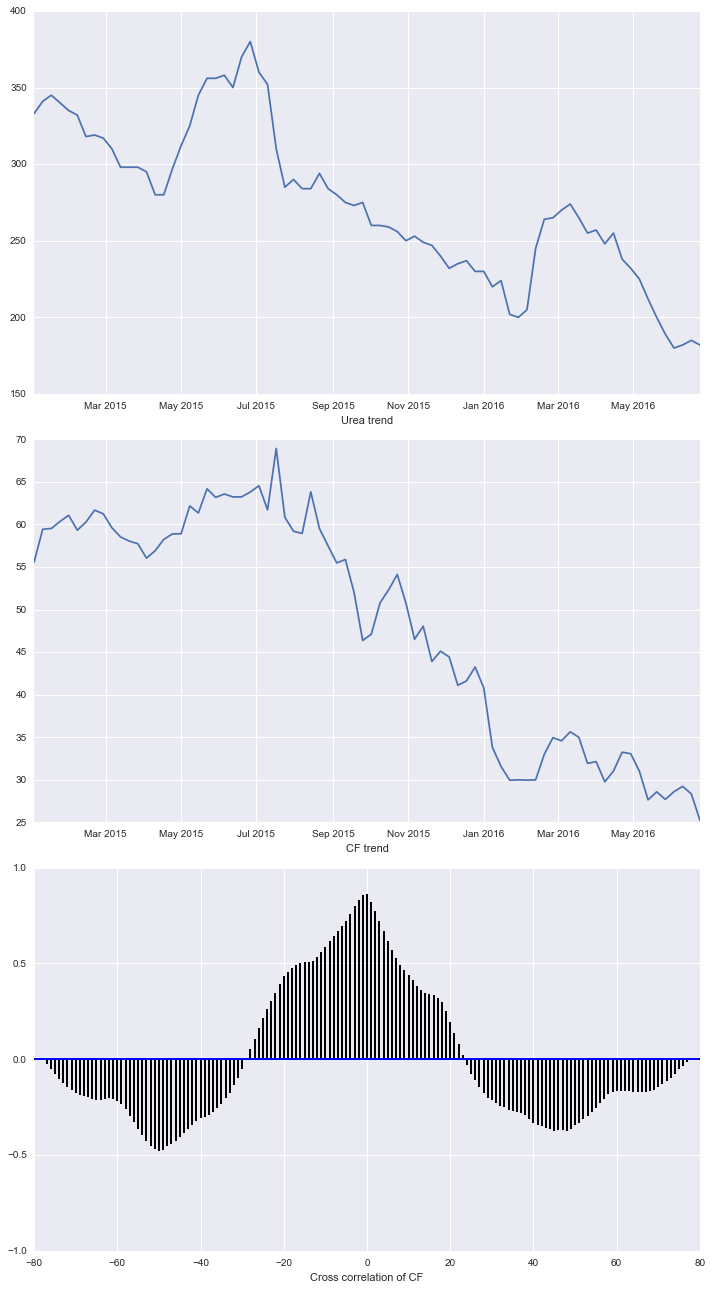

In [40]:
cf1 = df_15on[['CF']]
urea1 = df_15on[['Urea']]

#need in this format for bottom subplot
cf = np.array(cf1)
urea = np.array(urea1)
cf = np.ravel(cf) #said array was too deep before I did the ravel
urea = np.ravel(urea)

total = sum(urea)
av = total / len(urea)
z = [i - av for i in urea]

# Now let's generate random data for the same period
assert len(urea) == len(cf)

total1 = sum(cf)
av1 = total1 / len(cf)
z1 = [i - av1 for i in cf]

fig = plt.figure(figsize=(10,18))
    
# Search trend 
ax1 = fig.add_subplot(311)
ax1.plot(urea1)
ax1.set_xlabel('Urea trend')

# PCS: "search trend"
ax2 = fig.add_subplot(312)
ax2.plot(cf1)
ax2.set_xlabel('CF trend')

# Is there a pattern in search trend for this keyword?
ax3 = fig.add_subplot(313)
ax3.set_xlabel('Cross correlation of CF')
ax3.xcorr(z,z1,usevlines=True, maxlags=None, normed=True, lw=2)
ax3.grid(True)
plt.ylim(-1, 1)

plt.tight_layout()

plt.show()
#best correlation at lag 0

In [44]:
x = cf
y = urea
# this has cf starting at 0 and then it goes up to lead urea to 50
lagcorr(x,y,lag=-50,verbose=True)
#greatest correlation at 0 lag 0.86497


#<lagcorr>: Computing lagged-correlations at lags: [  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15 -16 -17
 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35
 -36 -37 -38 -39 -40 -41 -42 -43 -44 -45 -46 -47 -48 -49 -50]


array([[  8.64971461e-01,   1.83215782e-24],
       [  8.44551842e-01,   4.89173518e-22],
       [  8.20748149e-01,   1.13846720e-19],
       [  7.87314196e-01,   5.45692935e-17],
       [  7.55861824e-01,   7.00745751e-15],
       [  7.24349894e-01,   4.39049375e-13],
       [  6.95618427e-01,   1.18953806e-11],
       [  6.71622587e-01,   1.44479568e-10],
       [  6.49266221e-01,   1.20405847e-09],
       [  6.33801481e-01,   5.04756508e-09],
       [  6.20466359e-01,   1.66534993e-08],
       [  6.02762707e-01,   6.76590052e-08],
       [  5.89993265e-01,   1.85649360e-07],
       [  5.83598398e-01,   3.35565256e-07],
       [  5.80803614e-01,   4.87148063e-07],
       [  5.88159725e-01,   4.00220663e-07],
       [  5.98909691e-01,   2.71596506e-07],
       [  6.02888837e-01,   2.72452200e-07],
       [  5.95670062e-01,   5.14901555e-07],
       [  5.66243996e-01,   2.94884285e-06],
       [  5.29315442e-01,   1.93655629e-05],
       [  4.91983320e-01,   1.01549748e-04],
       [  